In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_18v2_csv.zip). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_18v2_csv/pluto_18v2.csv', low_memory=False) # Warning said to use 'low_memory=False' but I really have no idea why...


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['xcoord'] = 0.3048*ny['xcoord']
ny['ycoord'] = 0.3048*ny['ycoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### Binning Data

I spent an insane amount of time trying different methods of binning and grouping data and had a lot of trouble getting the data into the format needed in order to be able to plot in plotly.  I left a lot of the code below even though some of it wasn't really needed in order to show what I tried and keep as notes for future reference.

I binned data for the number of floors and for the decade in which a building was constructed and added those as new columns to the original dataframe as well as creating grouped aggragated dataframes with the same bins.  

I discoverd after MANY failures that in order to plot the data in plotly any categorical variables MUST have labels. Unlabeled columns just would not plot even if coverted to a list or series.  Indexes also had to be converted to columns with labels if they were categorical.

#### Number of Floors

In [5]:
# Start your answer here, inserting more cells as you go along

#ny[['numfloors','yearbuilt']][1:5]
#ny.groupby('yearbuilt').count()['bbl'].index

bins1 = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60, 75, 150, 300]
labels1 = ['1', '2', '3', '4', '5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-60', '61-75', '76-150', '151-300']
floors = pd.cut(ny['numfloors'], bins1, labels=labels1)

ny['numfloors_bins'] = floors
ny['numfloors_bins'].head()

0    2
1    3
2    2
3    2
4    3
Name: numfloors_bins, dtype: category
Categories (17, object): [1 < 2 < 3 < 4 ... 46-60 < 61-75 < 76-150 < 151-300]

##### Changed the code above and then updated the chart below to test different bin sizes and find appropriate cutoffs

In [6]:
Floors = pd.DataFrame(ny['numfloors'].groupby(floors).count())
Floors.columns = ['count']
Floors.reset_index(inplace=True)
Floors

numfloors   count
0          1   76698
1          2  451924
2          3  215571
3          4   28764
4          5   16914
5       6-10   17042
6      11-15    2660
7      16-20    1340
8      21-25     542
9      26-30     273
10     31-35     265
11     36-40     144
12     41-45     130
13     46-60     125
14     61-75      26
15    76-150      12
16   151-300       1

##### Test plot to make sure this works...

I also wanted to get an idea of the distribution of different size buildings.  The plot makes it clear that it will probably be necessary to log transform the data to see the distributions later since the bin for 2 story buildings is more than twice the size of any of the others and it can't be cut any smaller.

In [7]:
trace = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('numfloors_bins').count()['bbl'].index,
    y = ny.groupby('numfloors_bins').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'numfloors_bins'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

#### Year Built

In [8]:
bins2 = range(1850, 2021, 10)
labels2 = []
for year in range(1850, 2020, 10):
              labels2.append(str(year) + "'s")
dates = pd.cut(ny['yearbuilt'], bins2, labels=labels2)

ny['yearbuilt_bins'] = pd.cut(ny['yearbuilt'], bins2, labels=labels2)
ny['yearbuilt_bins'].head()

0    1920's
1    1930's
2    1970's
3    1910's
4    1920's
Name: yearbuilt_bins, dtype: category
Categories (17, object): [1850's < 1860's < 1870's < 1880's ... 1980's < 1990's < 2000's < 2010's]

##### Changed the code above and then updated the chart below to test different bin sizes and find appropriate cutoffs

In [9]:
Year_Built = pd.DataFrame(ny['yearbuilt'].groupby(dates).count())
Year_Built.columns = ['count']
Year_Built.reset_index(inplace=True)
Year_Built

yearbuilt   count
0     1850's     127
1     1860's     109
2     1870's     255
3     1880's     619
4     1890's   34483
5     1900's   82746
6     1910's  111565
7     1920's  166195
8     1930's  101321
9     1940's   75961
10    1950's   69893
11    1960's   42867
12    1970's   20947
13    1980's   25385
14    1990's   29697
15    2000's   40060
16    2010's   10201

##### Another test plot to make sure this works...

You can see a huge building boom in the 1920's!

In [10]:
trace = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt_bins').count()['bbl'].index,
    y = ny.groupby('yearbuilt_bins').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

#### Check the new columns in our dataframe...

In [11]:
ny.iloc[:, -2:].head(10)

numfloors_bins yearbuilt_bins
0               2         1920's
1               3         1930's
2               2         1970's
3               2         1910's
4               3         1920's
5               3         1920's
7            6-10         2000's
8               4         2000's
9               4         1980's
11              5         1890's

### Create new aggragated dataframe

After trying unsuccessfully many times to use the new categorical columns that I added to the original ny dataframe, I gave up and created a new dataframe with just the aggragated data for plotting...  Even this gave me problems until I finally figured out how to reset the index here: https://github.com/pandas-dev/pandas/issues/19136 

In [12]:
data = pd.DataFrame(ny['bbl'].groupby([floors, dates]).count().unstack())

#data.reset_index(inplace=True)  Throws error!!!!

# Got the function below here: https://github.com/pandas-dev/pandas/issues/19136
def reset_index(df):
  '''Returns DataFrame with index as columns'''
  index_df = df.index.to_frame(index=False)
  df = df.reset_index(drop=True)
  # In merge is important the order in which you pass the dataframes
  # if the index contains a Categorical. 
  # pd.merge(df, index_df, left_index=True, right_index=True) does not work
  return pd.merge(index_df, df, left_index=True, right_index=True)

data = reset_index(data)
data

numfloors  1850's  1860's  1870's  1880's   1890's   1900's   1910's  \
0          1     3.0     2.0     4.0    17.0    385.0   1507.0   3789.0   
1          2    11.0    49.0    68.0   150.0  11625.0  40174.0  59274.0   
2          3    42.0    31.0    76.0   247.0  14622.0  28371.0  37076.0   
3          4    48.0    16.0    34.0    91.0   3615.0   6044.0   4430.0   
4          5    14.0     8.0    46.0    74.0   2868.0   4321.0   4124.0   
5       6-10     8.0     2.0    26.0    37.0   1281.0   1956.0   2336.0   
6      11-15     1.0     1.0     1.0     3.0     65.0    323.0    427.0   
7      16-20     NaN     NaN     NaN     NaN     15.0     34.0     67.0   
8      21-25     NaN     NaN     NaN     NaN      6.0      8.0     22.0   
9      26-30     NaN     NaN     NaN     NaN      1.0      6.0     12.0   
10     31-35     NaN     NaN     NaN     NaN      NaN      1.0      3.0   
11     36-40     NaN     NaN     NaN     NaN      NaN      NaN      1.0   
12     41-45     NaN     NaN     NaN     NaN      NaN      1.0      2.0   
13     46-60     NaN     NaN     NaN     NaN      NaN      NaN      NaN   
14     61-75     NaN     NaN     NaN     NaN      NaN      NaN      1.0   
15    76-150     NaN     NaN     NaN     NaN      NaN      NaN      NaN   
16   151-300     NaN     NaN     NaN     NaN      NaN      NaN      1.0   

     1920's   1930's   1940's   1950's   1960's   1970's   1980's   1990's  \
0    7582.0  13612.0  14982.0  18099.0   8736.0   3093.0   1852.0   1376.0   
1   93462.0  56594.0  56169.0  40869.0  23061.0  13067.0  14199.0  18416.0   
2   52635.0  24421.0   3741.0   9119.0   9074.0   3924.0   8311.0   8751.0   
3    5213.0   3812.0    189.0    227.0    194.0    188.0    304.0    545.0   
4    2957.0    735.0    119.0    106.0     84.0     87.0     71.0    129.0   
5    3212.0   1950.0    643.0   1077.0    927.0    261.0    254.0    324.0   
6     583.0     78.0     75.0    167.0    236.0     85.0    112.0     52.0   
7     372.0     77.0     25.0    155.0    292.0     67.0     56.0     18.0   
8     104.0     11.0      9.0     41.0    130.0     34.0     48.0     18.0   
9      25.0      6.0      5.0     15.0     42.0     37.0     43.0     14.0   
10     21.0      9.0      1.0      9.0     39.0     52.0     42.0     25.0   
11     12.0      2.0      1.0      4.0     20.0     22.0     36.0     11.0   
12      9.0      5.0      1.0      3.0     19.0     16.0     28.0      5.0   
13      7.0      4.0      1.0      2.0     13.0     14.0     26.0     12.0   
14      1.0      3.0      NaN      NaN      NaN      NaN      2.0      1.0   
15      NaN      2.0      NaN      NaN      NaN      NaN      1.0      NaN   
16      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

     2000's  2010's  
0    1156.0   503.0  
1   20431.0  4305.0  
2   13055.0  2075.0  
3    2459.0  1355.0  
4     767.0   404.0  
5    1626.0  1122.0  
6     260.0   191.0  
7     101.0    61.0  
8      56.0    55.0  
9      36.0    31.0  
10     34.0    29.0  
11     22.0    13.0  
12     23.0    18.0  
13     28.0    18.0  
14      2.0    16.0  
15      4.0     5.0  
16      NaN     NaN

### Plot data for each year

After an insane amopunt of time trying all different kinds of plots and trying to tweak the labels etc...  This is the best I could come up with so far.  I still can't figure out how to fix a bunch of things that are bugging me:

1. Should have axis labels on the bottom and down the let side of the entire grid, but when IO tried to add them they wound up just on the first plot.  (I removed them since they were not working right)
2. Can't figure out how to leave the last spot in the grid blank. It automatically repeated the first trace there even though I didn't assign anything to that spot.
3. I'm not loving the log transfromaion, but it is harder to see bars for the taller buildings with the non-log transformed data
4. Can't figure out how to get ALL the plots to have the same y-axis, not just the same on each row...  As a result it's difficult to see the building boom in the 20's.  All the plots look like they have similar maximum numbers if you aren't paying attention to the axes.
5. I also would have liked to have the plots go three across, but when I had 3 columns every other label on the x-axis was missing because I guess the labels would have run into each other that way and I couldn't figure out how to change the size of the text for the labels.

In [13]:
fig = tools.make_subplots(cols = 2, rows = 9, print_grid = False, shared_yaxes=True, 
                          subplot_titles=(data.columns[1:]))

traces = []
for y in labels2:
    traces.append({'type' : 'bar',
                   'name' : y,
                   'x' : data['numfloors'].tolist(),
                   'y' : np.log10(data[y]).tolist()
                  })
traces.append(traces[0])

t=0
while t < 16:
    for r in range(1,10):
        for c in range(1,3):
            fig.append_trace(trace = traces[t], row = r, col = c)
            t +=1

fig['layout'].update(height=1500, width=800, title='Number of Floors - Log10 Transformed Building Counts', 
                     #xaxis = dict(title = 'Number of Floors'), yaxis = dict(title = 'Number of Lots Built'),
                     showlegend = False)

#fig = go.Figure(data = [traces[2]], layout = layout)

py.iplot(fig)

In [14]:
#help(tools.make_subplots)
fig

Figure({
    'data': [{'name': "1850's",
              'type': 'bar',
              'uid': '11580b74-ff6d-4e1d-a07f-5b1ab5b07d66',
              'x': [1, 2, 3, 4, 5, 6-10, 11-15, 16-20, 21-25, 26-30, 31-35, 36-40,
                    41-45, 46-60, 61-75, 76-150, 151-300],
              'xaxis': 'x',
              'y': [0.47712125471966244, 1.0413926851582251, 1.6232492903979006,
                    1.6812412373755872, 1.146128035678238, 0.9030899869919435, 0.0,
                    nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
              'yaxis': 'y'},
             {'name': "1860's",
              'type': 'bar',
              'uid': '46e8001a-2b4d-4b0d-9947-c8a61781c449',
              'x': [1, 2, 3, 4, 5, 6-10, 11-15, 16-20, 21-25, 26-30, 31-35, 36-40,
                    41-45, 46-60, 61-75, 76-150, 151-300],
              'xaxis': 'x2',
              'y': [0.3010299956639812, 1.6901960800285136, 1.4913616938342726,
                    1.2041199826559248, 0.9030899869919435, 0

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [15]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data)

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



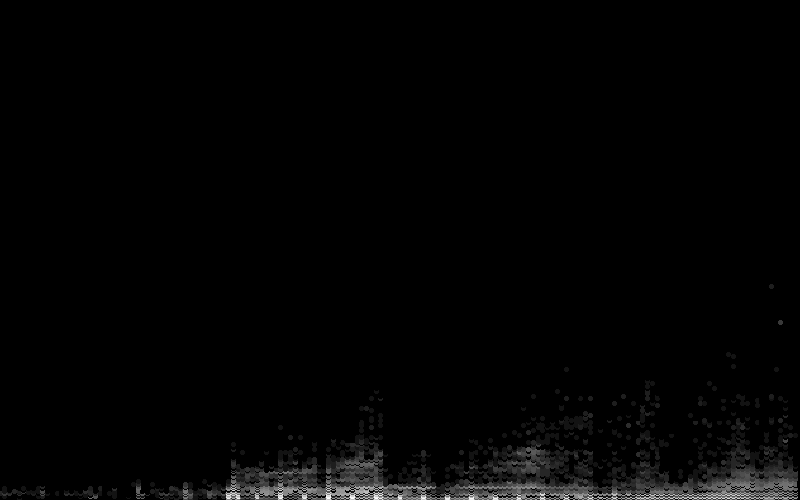

In [9]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

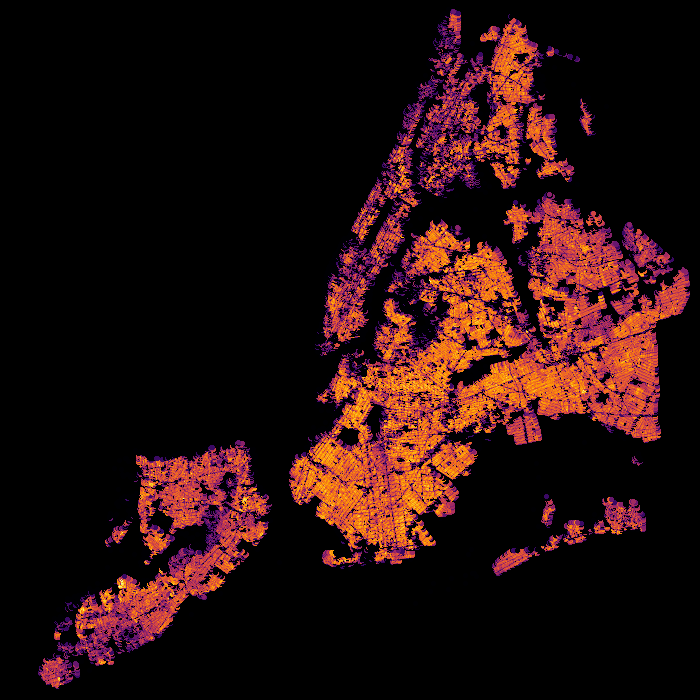

In [10]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

In [26]:
# assuming that this is a valid calculation?  
# Makes sense that the total value minus the land value should equal the structure value, right?
ny['assessstructure'] = ny['assesstot'] - ny['assessland']
ny[['assessland', 'assessstructure', 'assesstot']].head(12)

assessland  assessstructure  assesstot
0       6787.0          23901.0    30688.0
1       9758.0          24996.0    34754.0
2      67764.0        1289409.0  1357173.0
3      12191.0          26110.0    38301.0
4      13079.0          17377.0    30456.0
5       8341.0          25167.0    33508.0
7      56258.0        1270348.0  1326606.0
8       3761.0          79308.0    83069.0
9      43105.0         189069.0   232174.0
11     68492.0         609174.0   677666.0
12      1680.0         201776.0   203456.0
13     11083.0          82753.0    93836.0

In [25]:
val_labels = ['low', 'med', 'high']
ny['land_group'] = pd.qcut(ny['assessland'], 3, labels=val_labels)
ny['structure_group'] = pd.qcut(ny['assessstructure'], 3, labels=val_labels)
ny[['land_group', 'structure_group']].head(12)

land_group structure_group
0         low             med
1         med             med
2        high            high
3        high             med
4        high             low
5         med             med
7        high            high
8         low            high
9        high            high
11       high            high
12        low            high
13        med            high

In [31]:
ny['land_group'].value_counts()

med     270827
low     270819
high    270785
Name: land_group, dtype: int64

In [32]:
ny['structure_group'].value_counts()

low     270828
high    270804
med     270799
Name: structure_group, dtype: int64

In [36]:
ny['combined_value'] = ny['land_group'].str.cat(ny['structure_group'].values.astype(str), sep='-')
ny['combined_value'] = pd.Categorical(ny['combined_value'])
ny['combined_value'].head(12)

0       low-med
1       med-med
2     high-high
3      high-med
4      high-low
5       med-med
7     high-high
8      low-high
9     high-high
11    high-high
12     low-high
13     med-high
Name: combined_value, dtype: category
Categories (9, object): [high-high, high-low, high-med, low-high, ..., low-med, med-high, med-low, med-med]

<img src="color_scale.png">

/Users/betsyrosalen/anaconda3/lib/python3.6/site-packages/datashader/utils.py:348: FutureWarning:

`Series.cat.categorical` has been deprecated. Use the attributes on 'Series.cat' directly instead.



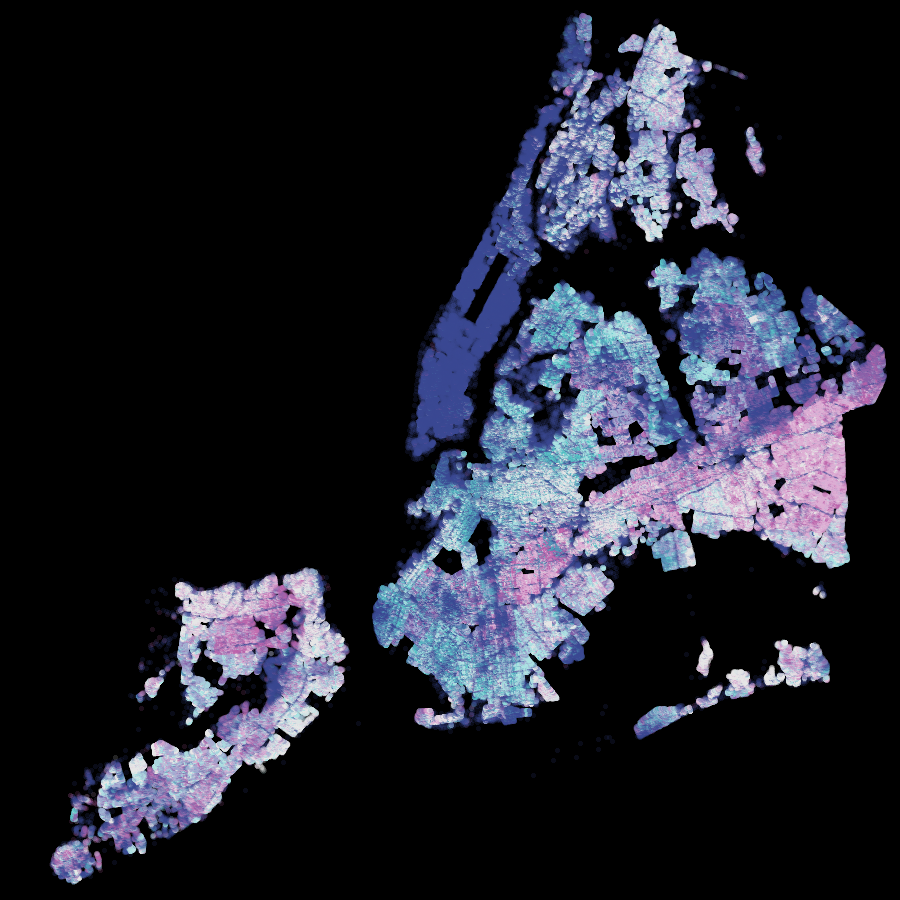

In [46]:
# land values range from gray to bright pink and structure values range from gray to bright blue
colors = {'low-low': '#e8e8e8',
          'low-med': '#ace4e4',
          'low-high': '#5ac8c8',
          'med-low': '#dfb0d6',
          'med-med': '#a5add3',
          'med-high': '#5698b9',
          'high-low': '#be64ac',
          'high-med': '#8c62aa',
          'high-high': '#3b4994'
}

# Recycle long / lat settings and datashader call from above
NewYorkCity = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(900, 900, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('combined_value'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=2), 'pretty_colors')